In [1]:
import os, sys
import glob
import zipfile
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer

import IPython.display as display
from matplotlib import animation


from gsc_dataset import GSCDataset

# Create Dataset

The dataset class follows standard torch dataset definition. They are defined in `nmnist.py`. We will just import the dataset and augmentation routine here.

# Create Network

A slayer network definition follows standard PyTorch way using `torch.nn.Module`.

The network can be described with a combination of individual `synapse`, `dendrite`, `neuron` and `axon` components. For rapid and easy development, slayer provides __block interface__ - `slayer.block` - which bundles all these individual components into a single unit. These blocks can be cascaded to build a network easily. The block interface provides additional utilities for normalization (weight and neuron), dropout, gradient monitoring and network export.

In the example below, `slayer.block.cuba` is illustrated.

In [2]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,     
            }
        neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}
        
        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params_drop, 80, 512, weight_norm=True, delay=False),
                #slayer.block.cuba.Dense(neuron_params_drop, 512, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 512, 35, weight_norm=True),
            ])
    
    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike
    
    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

# Instantiate Network, Optimizer, DataSet and DataLoader

Running the network in GPU is as simple as selecting `torch.device('cuda')`.

In [3]:
NETWORK_SCALE = 0.02

In [4]:
# Load dataset

dir = "/mnt/data0/ts468/data/rawSC/rawSC_80input/"

x_train = np.load(os.path.expanduser(dir) + "training_x_data.npy")
y_train = np.load(os.path.expanduser(dir) + "training_y_data.npy")

x_test = np.load(os.path.expanduser(dir) + "testing_x_data.npy")
y_test = np.load(os.path.expanduser(dir) + "testing_y_data.npy")

if NETWORK_SCALE < 1:
        assert len(x_train) == len(y_train)
        p = np.random.permutation(len(x_train))
        x_train, y_train = x_train[p], y_train[p]
        print(f"original network size: {len(x_train)}")
        x_train = x_train[:int(len(x_train) * NETWORK_SCALE)]
        y_train = y_train[:int(len(y_train) * NETWORK_SCALE)]
        print(f"reduced network size: {len(x_train)}")
        print("!! network reduced")

training_images = x_train #np.swapaxes(x_train, 1, 2) 
testing_images = x_test #np.swapaxes(x_test, 1, 2) 

training_images = training_images + abs(np.floor(training_images.min()))
testing_images = testing_images + abs(np.floor(testing_images.min()))

training_labels = y_train
testing_labels = y_test

# adding validation data if exists
validation_images = np.array([])
validation_labels = np.array([])
if os.path.isfile(os.path.expanduser(dir) + "validation_y_data.npy"):
        print("!! validation dataset loaded successfully")
        x_validation = np.load(os.path.expanduser(dir) + "validation_x_data.npy")
        y_validation = np.load(os.path.expanduser(dir) + "validation_y_data.npy")

        validation_images = x_validation #np.swapaxes(x_validation, 1, 2) 
        validation_images = validation_images + abs(np.floor(validation_images.min()))

        validation_labels = y_validation

"""training_images = np.expand_dims(training_images, 1)
testing_images = np.expand_dims(testing_images, 1)
validation_images = np.expand_dims(validation_images, 1)"""

original network size: 94824
reduced network size: 1896
!! network reduced
!! validation dataset loaded successfully


'training_images = np.expand_dims(training_images, 1)\ntesting_images = np.expand_dims(testing_images, 1)\nvalidation_images = np.expand_dims(validation_images, 1)'

In [5]:
batch = 8

# Datasets
training_set = GSCDataset(
    data = training_images, 
    targets = training_labels)

testing_set = GSCDataset(
data = training_images, 
targets = training_labels)

train_loader = DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=batch, shuffle=True)

In [6]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

#device = torch.device('cpu')
device = torch.device('cuda') 

net = Network().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [7]:
"""trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

# device = torch.device('cpu')
device = torch.device('cuda') 

net = Network().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

training_set = NMNISTDataset(train=True, transform=augment)
testing_set  = NMNISTDataset(train=False)

train_loader = DataLoader(dataset=training_set, batch_size=32, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=32, shuffle=True)"""

"trained_folder = 'Trained'\nos.makedirs(trained_folder, exist_ok=True)\n\n# device = torch.device('cpu')\ndevice = torch.device('cuda') \n\nnet = Network().to(device)\n\noptimizer = torch.optim.Adam(net.parameters(), lr=0.001)\n\ntraining_set = NMNISTDataset(train=True, transform=augment)\ntesting_set  = NMNISTDataset(train=False)\n\ntrain_loader = DataLoader(dataset=training_set, batch_size=32, shuffle=True)\ntest_loader  = DataLoader(dataset=testing_set , batch_size=32, shuffle=True)"

# Visualize the input data

A `slayer.io.Event` can be visualized by invoking it's `Event.show()` routine. `Event.anim()` instead returns the event visualization animation which can be embedded in notebook or exported as video/gif. Here, we will export gif animation and visualize it.

In [8]:
"""for i in range(5):
    spike_tensor, label = testing_set[np.random.randint(len(testing_set))]
    spike_tensor = spike_tensor.reshape(2, 34, 34, -1)
    event = slayer.io.tensor_to_event(spike_tensor.cpu().data.numpy())
    anim = event.anim(plt.figure(figsize=(5, 5)), frame_rate=240)
    anim.save(f'gifs/input{i}.gif', animation.PillowWriter(fps=24), dpi=300)"""

"for i in range(5):\n    spike_tensor, label = testing_set[np.random.randint(len(testing_set))]\n    spike_tensor = spike_tensor.reshape(2, 34, 34, -1)\n    event = slayer.io.tensor_to_event(spike_tensor.cpu().data.numpy())\n    anim = event.anim(plt.figure(figsize=(5, 5)), frame_rate=240)\n    anim.save(f'gifs/input{i}.gif', animation.PillowWriter(fps=24), dpi=300)"

In [9]:
"""gif_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 250px;"/> </td>'
header = '<table><tr>'
images = ' '.join([gif_td(f'gifs/input{i}.gif') for i in range(5)])
footer = '</tr></table>'
display.HTML(header + images + footer)"""

'gif_td = lambda gif: f\'<td> <img src="{gif}" alt="Drawing" style="height: 250px;"/> </td>\'\nheader = \'<table><tr>\'\nimages = \' \'.join([gif_td(f\'gifs/input{i}.gif\') for i in range(5)])\nfooter = \'</tr></table>\'\ndisplay.HTML(header + images + footer)'

# Error module

Slayer provides prebuilt loss modules: `slayer.loss.{SpikeTime, SpikeRate, SpikeMax}`.
* `SpikeTime`: precise spike time based loss when target spike train is known.
* `SpikeRate`: spike rate based loss when desired rate of the output neuron is known.
* `SpikeMax`: negative log likelihood losses for classification without any rate tuning.

Since the target spike train is not known for this problem, we use `SpikeRate` loss and target high spiking rate for true class and low spiking rate for false class.

target rate: $\hat{\boldsymbol r} = r_\text{true}\,{\bf 1}[\text{label}] + r_\text{false}\,(1-{\bf 1}[\text{label}])$ where ${\bf 1}[\text{label}]$ is one-hot encoding of label. The loss is:

$$L = \frac{1}{2} \left(\frac{1}{T}\int_T {\boldsymbol s}(t)\,\text dt -  \hat{\boldsymbol r}\right)^\top {\bf 1}$$

In [10]:
error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device)

# Stats and Assistants

Slayer provides `slayer.utils.LearningStats` as a simple learning statistics logger for training, validation and testing.

In addtion, `slayer.utils.Assistant` module wraps common training validation and testing routine which help simplify the training routine.

In [11]:
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

# Training Loop

Training loop mainly consists of looping over epochs and calling `assistant.train` and `assistant.test` utilities over training and testing dataset. The `assistant` utility takes care of statndard backpropagation procedure internally.

* `stats` can be used in print statement to get formatted stats printout.
* `stats.testing.best_accuracy` can be used to find out if the current iteration has the best testing accuracy. Here, we use it to save the best model.
* `stats.update()` updates the stats collected for the epoch.
* `stats.save` saves the stats in files.

In [12]:
epochs = 10

for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader): # training loop
        output = assistant.train(input, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    for i, (input, label) in enumerate(test_loader): # training loop
        output = assistant.test(input, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    if epoch%20 == 19: # cleanup display
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        stats_str = str(stats).replace("| ", "\n")
        print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')
    
    if stats.testing.best_accuracy:
        pass
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    net.grad_flow(trained_folder + '/')

[Epoch  9/10] Train loss =     0.46342 (min =     0.57263)     accuracy = 0.03586 (max = 0.03692)  | Test  loss =     0.40621 (min =     0.51799)     accuracy = 0.03745 (max = 0.04905) 

# Plot the learning curves

Plotting the learning curves is as easy as calling `stats.plot()`.

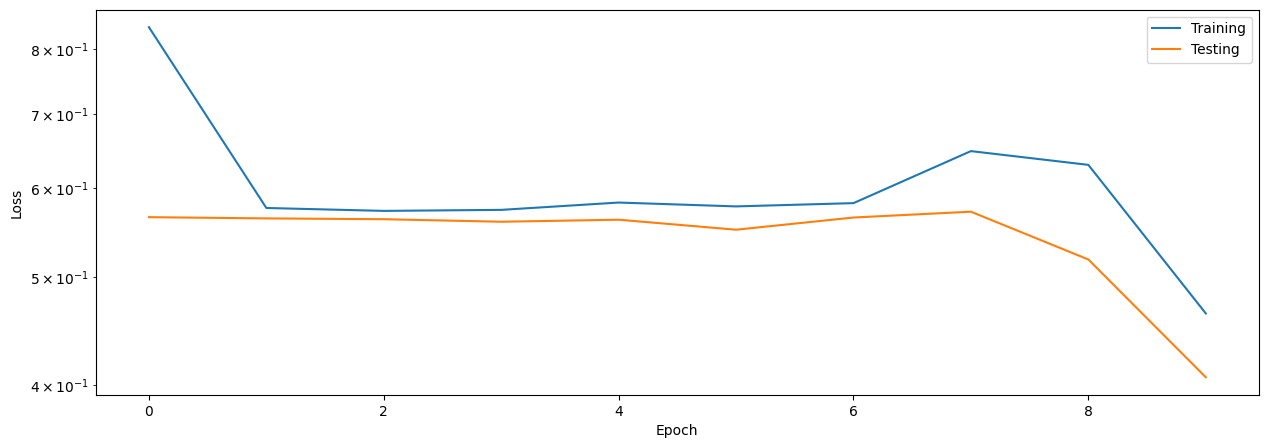

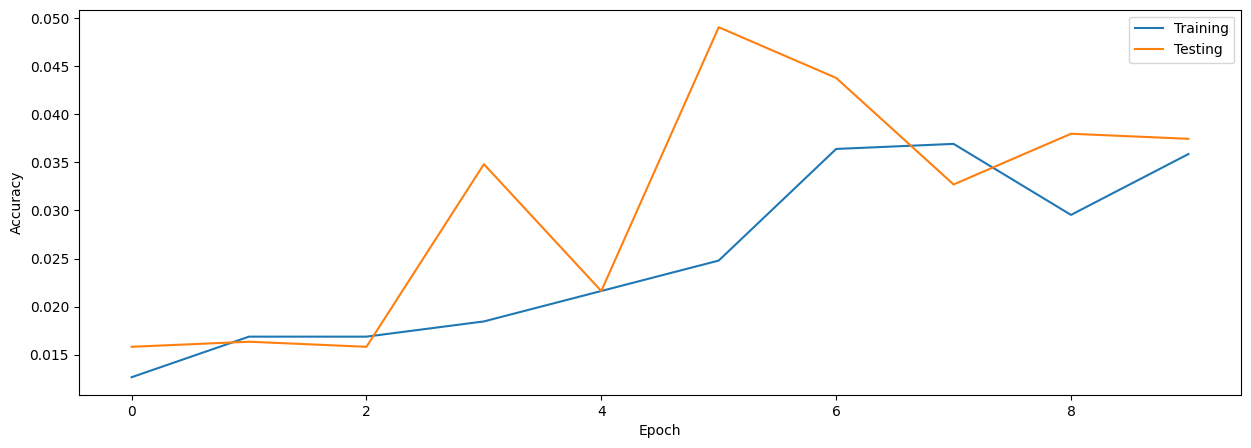

In [13]:
stats.plot(figsize=(15, 5))

# Export the best model

Load the best model during training and export it as hdf5 network. It is supported by `lava.lib.dl.netx` to automatically load the network as a lava process.

In [14]:
net.load_state_dict(torch.load(trained_folder + '/network.pt'))
net.export_hdf5(trained_folder + '/network.net')

In [23]:
net.blocks[0].synapse._parameters["weight"]

Parameter containing:
tensor([[[[[ 0.0398]]],


         [[[-0.0136]]],


         [[[-0.0587]]],


         ...,


         [[[-0.0709]]],


         [[[-0.0904]]],


         [[[-0.0377]]]],



        [[[[ 0.0025]]],


         [[[-0.0165]]],


         [[[ 0.0384]]],


         ...,


         [[[-0.0896]]],


         [[[ 0.1202]]],


         [[[-0.0806]]]],



        [[[[ 0.0148]]],


         [[[ 0.0295]]],


         [[[ 0.0958]]],


         ...,


         [[[-0.0554]]],


         [[[ 0.0762]]],


         [[[-0.1002]]]],



        ...,



        [[[[ 0.0170]]],


         [[[ 0.1177]]],


         [[[-0.0413]]],


         ...,


         [[[ 0.0490]]],


         [[[ 0.0498]]],


         [[[-0.0035]]]],



        [[[[-0.0957]]],


         [[[ 0.0183]]],


         [[[-0.1206]]],


         ...,


         [[[-0.0468]]],


         [[[-0.0244]]],


         [[[-0.1008]]]],



        [[[[ 0.0137]]],


         [[[-0.0581]]],


         [[[ 0.0269]]],


         ...,


# Visualize the network output

Here, we will use `slayer.io.tensor_to_event` method to convert the torch output spike tensor into `slayer.io.Event` object and visualize a few input and output event pairs.

In [26]:
output = net(input.to(device))
for i in range(5):
    inp_event = slayer.io.tensor_to_event(input[i].cpu().data.numpy().reshape(1, 80, 100, -1))
    out_event = slayer.io.tensor_to_event(output[i].cpu().data.numpy().reshape(1, 10, -1))
    inp_anim = inp_event.anim(plt.figure(figsize=(5, 5)), frame_rate=240)
    out_anim = out_event.anim(plt.figure(figsize=(10, 5)), frame_rate=240)
    inp_anim.save(f'gifs/inp{i}.gif', animation.PillowWriter(fps=24), dpi=300)
    out_anim.save(f'gifs/out{i}.gif', animation.PillowWriter(fps=24), dpi=300)


/its/home/ts468/PhD/ve/genn_4_9/lib/python3.8/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
/its/home/ts468/PhD/ve/genn_4_9/lib/python3.8/site-packages/matplotlib/animation.py:1740: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


IndexError: list index out of range

In [16]:
"""html = '<table>'
html += '<tr><td align="center"><b>Input</b></td><td><b>Output</b></td></tr>'
for i in range(5):
    html += '<tr>'
    html += gif_td(f'gifs/inp{i}.gif')
    html += gif_td(f'gifs/out{i}.gif')
    html += '</tr>'
html += '</tr></table>'
display.HTML(html)"""

'html = \'<table>\'\nhtml += \'<tr><td align="center"><b>Input</b></td><td><b>Output</b></td></tr>\'\nfor i in range(5):\n    html += \'<tr>\'\n    html += gif_td(f\'gifs/inp{i}.gif\')\n    html += gif_td(f\'gifs/out{i}.gif\')\n    html += \'</tr>\'\nhtml += \'</tr></table>\'\ndisplay.HTML(html)'